/var/folders/c3/_byqmhpx62b_f0jnb2ht27y40000gn/T/ipykernel_35109/462642103.py:37: UserWarning: You are using a value of 1 that is almost 1. Values very                                near 1 result in the use of a gaussian
  warnings.warn("You are using a value of 1 that is almost 1. Values very \


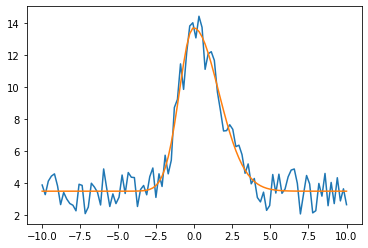

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import time
import numba
class qGaussianHelper:
    #The q gauss function require some boolean logic, so it is not trivial to make a version that
    #works with numpy. This class carries a version for looping and a version for numpy arrays
    #for convenience sake. It also carries a method to compute the FWHM give the parameters
    def __init__(self):
        self.num_qGaussArgs=6
        self._qGaussian_Numpy=np.vectorize(self._qGaussian_Scalar)#(x,mu,a,b,sigma,q,eta) #a version that works with numpy arrays
    def __call__(self,x,mu,a,b,sigma,q,eta):
        if isinstance(x,float):
            return self._qGaussian_Scalar(x,mu,a,b,sigma,q,eta)
        else:
            return self._qGaussian_Numpy(x,mu,a,b,sigma,q,eta)
    @staticmethod
    def _qGaussian_Scalar(x,mu,a,b,sigma,q,eta):
        # see: https://en.wikipedia.org/wiki/Q-Gaussian_distribution
        #a: height
        #b: offset
        #sigma: when q=1 this is the normal sigma
        #q: the q value. for 1<q<3 this generates a distribution with heavier tails. when q=1
        #you have a normal distribution back, but this requires a limits which cannot be done here,
        #so a gaussian function is used for q very close to 1.0.
        #eta: drives lopsidedness. if eta is positive, sigma is scaled by eta on the right of the peak as (1+eta).
        #if negative, it's on the left side as (1+abs(eta))
        assert a>0.0 and sigma>0.0 and q>0.0
        if x-mu>=0.0:
            eta=max(eta,0.0)
            x=-(1/2)*((x-mu)/(sigma*(1+eta)))**2
        else:
            eta=abs(min(eta,0.0))
            x=-(1/2)*((x-mu)/(sigma*(1+eta)))**2
        if 1-1e-6<q<1+1e-6:
            if q!=1.0: 
                warnings.warn("You are using a value of 1 that is almost 1. Values very \
                               near 1 result in the use of a gaussian")
            val=math.exp(x)
        else:
            term=(1+(1-q)*x)
            exponent=(1/(1-q))
            if term<0.0: val=0.0
            else: val=term**exponent
        assert val>=0.0
        val=a*val+b
        return val
    def get_FWHM(self,mu,a,b,sigma,q,eta,plotResults=False):
        #given the parameters of the qGaussian, return the FWHM. Uses numeric methods.
        #uses the symmetry of the distribution and searches only 1 half
        muSearch=0.0 #center the distribution
        numSigmasWidth=5
        xArr=np.linspace(-numSigmasWidth*sigma,0.0,10_000)
        yArr=self.__call__(xArr,muSearch,1.0,0.0,sigma,q,eta)
        assert np.min(yArr)<a/100.0+b,'not accurate if the function doenst go to very near b'
        leftHM=xArr[np.argmax(yArr>=.5)]
        FWHM=abs(2*leftHM)
        if plotResults==True:
            plt.plot(xArr,yArr,c='b')
            plt.plot(-xArr,yArr,c='b')
            plt.axvline(x=leftHM,c='black')
            plt.axvline(x=-leftHM,c='black')
            plt.grid()
            plt.show()
from scipy.optimize import curve_fit
test=qGaussianHelper()
xArr=np.linspace(-10,10,100)
y=test(xArr,0.0,10,2.0,1.0,1.1,.5)+3*np.random.rand(xArr.shape[0])

bounds=[(-np.inf,0.0,-np.inf,0,0,-np.inf),(np.inf,np.inf,np.inf,np.inf,np.inf,np.inf)]
params=curve_fit(test,xArr,y,bounds=bounds)[0]


plt.plot(xArr,y)
plt.plot(xArr,test(xArr,*params))
plt.show()
